In [1]:
import sys
import os

sys.path.append(os.path.abspath('..'))

In [2]:
from utils import get_cuda_info

get_cuda_info()

PyTorch version: 2.5.1+cu118
**********
_CUDA version: 
CUDA version:
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Wed_Oct_30_01:18:48_Pacific_Daylight_Time_2024
Cuda compilation tools, release 12.6, V12.6.85
Build cuda_12.6.r12.6/compiler.35059454_0

**********
CUDNN version: 90100
Available GPU devices: 1
Device Name: NVIDIA GeForce RTX 4070 Ti SUPER


## Wybór optymalnych punktów charakterystycznych

In [3]:
import numpy as np

LANDMARK_INDEXES = np.load(os.path.join('..', '..', 'data', 'landmarks', 'combined_selected_points.npy'))
REFERENCE_POINT_IDX = 0

### Wizualizacja wybranych punktów

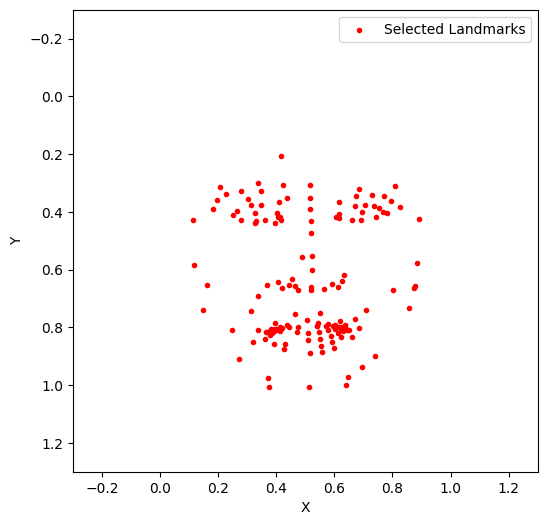

In [4]:
from utils import visualize_landmarks

visualize_landmarks(LANDMARK_INDEXES)

### Zdobycie danych

In [11]:
from utils import load_data, convert_landmarks_to_distances

all_data, all_labels = load_data('nemo_smile')
all_data = convert_landmarks_to_distances(all_data, LANDMARK_INDEXES, REFERENCE_POINT_IDX, normalize=True)

## Preprocessing danych

In [12]:
from utils import preprocess_data

X_train, X_val, X_test, y_train, y_val, y_test = preprocess_data(all_data, all_labels, binarize_labels=False)

In [13]:
print(X_train.shape)
print(y_train.shape)

torch.Size([868, 609, 154])
torch.Size([868])


In [14]:
from utils import get_class_distribution

get_class_distribution(all_labels)

===> Class distribution <===
0: 597
1: 643
=============><=============


# MODEL TORCH

### W podejściu wykorzystane zostaną 2 modele - pierwszy z nich będzie siecią konwolucyjną 2d, która będzie miała za zadanie nauczyć się rozpoznawać cechy charakterystyczne dla wybranej klatki (zbioru współrzędnych pkt charakterystycznych). Do klasyfikacji szeregu czasowego zostanie wykorzystana sekwencyjna sieć neuronowa LSTM.

## Zbudowanie modelu ekstrakcji cech

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [9]:
class LieClassifier(nn.Module):
    def __init__(self, input_distances):
        super(LieClassifier, self).__init__()
        
        # Spatial feature extraction (changed in_channels to 1)
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        
        # Calculate LSTM input dimension
        self.conv_output_size = 64 * (input_distances // 4)  # After two poolings
        
        # Temporal feature extraction
        self.lstm = nn.LSTM(input_size=self.conv_output_size, hidden_size=128,
                          batch_first=True, bidirectional=True)
        
        # Classification head
        self.attn = nn.Linear(256, 1)
        self.fc1 = nn.Linear(256, 64)  # 128*2 for bidirectional
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 1)
        
        self._init_weights()

    def _init_weights(self):
        for name, param in self.named_parameters():
            if 'weight' in name:
                nn.init.xavier_normal_(param)
            elif 'bias' in name:
                nn.init.constant_(param, 0.1)

    def forward(self, x):
        # x shape: (batch_size, frames, distances)
        batch_size, frames, distances = x.shape
        
        # Reshape for Conv1D: (batch*frames, 1, distances)
        x = x.view(-1, 1, distances)
        
        # Spatial features
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        
        # Prepare for LSTM
        x = x.view(batch_size, frames, -1)
        
        # Temporal features
        x, _ = self.lstm(x)
        attn_weights = torch.softmax(self.attn(x), dim=1)
        x = (x * attn_weights).sum(dim=1)
        
        # Classification head (remove sigmoid!)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)  # Raw logits

In [17]:
from torch.optim import Adam

model = LieClassifier(input_distances=len(LANDMARK_INDEXES))
pos_weight = torch.tensor([(len(y_train) - y_train.sum()) / y_train.sum()]).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = Adam(model.parameters(), lr=1e-4)

### Diagnostyka

In [22]:
from utils.model_functions import overfit_model

model_diag = LieClassifier(input_distances=len(LANDMARK_INDEXES))
criterion_diag = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer_diag = Adam(model.parameters(), lr=1e-3)

overfit_model(model_diag, criterion_diag, optimizer_diag, X_train, y_train, prediction_treshold=0.5)


=== Debug Mode ===
Input shape: torch.Size([32, 609, 154])
Label distribution: 0.66 (1s)

Step 0:
Loss: 0.6271
Accuracy: 56.25%
Predictions (5 samples): [0.4063 0.5719 0.6382 0.5509 0.5415]
Labels (5 samples): [1. 0. 1. 0. 1.]
Param conv1.weight: shape (32, 1, 3) | grad norm: 0.027005
Param conv1.bias: shape (32,) | grad norm: 0.096207
Param conv2.weight: shape (64, 32, 3) | grad norm: 0.136927
Param conv2.bias: shape (64,) | grad norm: 0.124403
Param lstm.weight_ih_l0: shape (512, 2432) | grad norm: 0.392871
Param lstm.weight_hh_l0: shape (512, 128) | grad norm: 0.109606
Param lstm.bias_ih_l0: shape (512,) | grad norm: 0.056534
Param lstm.bias_hh_l0: shape (512,) | grad norm: 0.056534
Param lstm.weight_ih_l0_reverse: shape (512, 2432) | grad norm: 0.457260
Param lstm.weight_hh_l0_reverse: shape (512, 128) | grad norm: 0.135324
Param lstm.bias_ih_l0_reverse: shape (512,) | grad norm: 0.066103
Param lstm.bias_hh_l0_reverse: shape (512,) | grad norm: 0.066103
Param attn.weight: shape (1

KeyboardInterrupt: 

## Trening modelu

In [18]:
from torch.utils.tensorboard import SummaryWriter

RUNS_FOLDER_PATH = os.path.abspath('runs')
writer_path = os.path.join('runs', 'torch_lstm', 'lie_classifier_landmark_distance_normalized')
writer = SummaryWriter(writer_path)

In [19]:
from utils.model_functions import train_torch_model_binary

train_torch_model_binary(model, criterion, optimizer, X_train, y_train, X_val, y_val, unbalanced=True, writer=writer, prediction_treshold=0.5)

Epoch 1/300, Train Loss: 17.67683303, Train Acc: 0.55299539, Val Loss: 3.50655770, Val Acc: 0.67204301
Epoch 2/300, Train Loss: 15.55383250, Train Acc: 0.69239631, Val Loss: 3.28689194, Val Acc: 0.73118280
Epoch 3/300, Train Loss: 15.42053059, Train Acc: 0.67396313, Val Loss: 3.48408949, Val Acc: 0.67741935
Epoch 4/300, Train Loss: 15.06688705, Train Acc: 0.71082949, Val Loss: 3.35401917, Val Acc: 0.70430108
Epoch 5/300, Train Loss: 14.98503661, Train Acc: 0.73041475, Val Loss: 3.17962787, Val Acc: 0.73118280
Epoch 6/300, Train Loss: 14.78154027, Train Acc: 0.73502304, Val Loss: 3.17293599, Val Acc: 0.66666667
Epoch 7/300, Train Loss: 14.53898847, Train Acc: 0.73387097, Val Loss: 3.18807545, Val Acc: 0.65591398
Epoch 8/300, Train Loss: 13.87881291, Train Acc: 0.76267281, Val Loss: 3.10582122, Val Acc: 0.72580645
Epoch 9/300, Train Loss: 13.42370999, Train Acc: 0.75806452, Val Loss: 3.28144169, Val Acc: 0.62903226
Epoch 10/300, Train Loss: 14.20917526, Train Acc: 0.74539171, Val Loss: 3

KeyboardInterrupt: 

## Ewaluacja modelu

In [20]:
from utils.model_functions import eval_torch_model_binary

eval_torch_model_binary(model, criterion, X_test, y_test)

Test Loss: 0.0185, Test Accuracy: 0.6882


## Model Seglearn

In [23]:
from xgboost import XGBClassifier
from seglearn.pipe import Pype
from seglearn.transform import FeatureRep, Segment

In [24]:
X_train_np = X_train.numpy()
X_val_np = X_val.numpy()
X_test_np = X_test.numpy()
y_train_np = y_train.numpy()
y_val_np = y_val.numpy()
y_test_np = y_test.numpy()

In [25]:
X_train_np.shape

(868, 609, 154)

In [26]:
y_train_np.shape

(868,)

### Budowa modelu

In [27]:
pipe = Pype([
    ("segment", Segment(width=20, step=10)),  # Segmentacja sekwencji
    ("features", FeatureRep()),              # Ekstrakcja cech
    ("xgb", XGBClassifier(
        eval_metric='logloss',
        n_estimators=200
    ))
])

### Trening modelu

In [28]:
pipe.fit(X_train_np, y_train_np)

Pype(steps=[('segment', Segment(overlap=None, step=10, width=20)),
            ('features',
             FeatureRep(features={'abs_energy': <function abs_energy at 0x000002761D1DAFC0>,
                                  'kurt': <function kurt at 0x000002761D1DB4C0>,
                                  'max': <function maximum at 0x000002761D1DB380>,
                                  'mean': <function mean at 0x000002761D1DAC00>,
                                  'median': <function median at 0x000002761D1DACA0>,
                                  'min': <function minimum at 0x...
                           gamma=None, grow_policy=None, importance_type=None,
                           interaction_constraints=None, learning_rate=None,
                           max_bin=None, max_cat_threshold=None,
                           max_cat_to_onehot=None, max_delta_step=None,
                           max_depth=None, max_leaves=None,
                           min_child_weight=None, missing=nan,
                           monotone_constraints=None, multi_strategy=None,
                           n_estimators=200, n_jobs=None,
                           num_parallel_tree=None, random_state=None, ...))])

### Ewaluacja modelu

In [30]:
val_accuracy = pipe.score(X_val_np, y_val_np)
test_accuracy = pipe.score(X_test_np, y_test_np)

print(f"Dokładność na zbiorze walidacyjnym: {val_accuracy:.2f}")
print(f"Dokładność na zbiorze testowym: {test_accuracy:.2f}")

Dokładność na zbiorze walidacyjnym: 0.56
Dokładność na zbiorze testowym: 0.55
